# Stock price prediction

We want to predict the stock price of a dataset using a recurrent neural network, in our case we will try to predict the **Close** price.

We import everything that we need here, to have them all in a place.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

## Load dataset

We will use *yFinance* to get the stock prices from a company
company stocks(AMZN, AAPL, MSFT, etc.)

In [2]:
end = datetime.now()
start = datetime(2019, end.month, end.day)
dataset = yf.download("AMZN", start, end)
dataset.shape

[*********************100%%**********************]  1 of 1 completed


(1259, 6)

## Inspect dataset

Let's see the dataset that we have

In [3]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,176.940002,178.869995,174.559998,177.229996,177.229996,37924900
2024-04-23,178.080002,179.929993,175.979996,179.539993,179.539993,37046500
2024-04-24,179.940002,180.320007,176.179993,176.589996,176.589996,34185100
2024-04-25,169.679993,173.919998,166.320007,173.669998,173.669998,49249400
2024-04-26,177.800003,180.820007,176.130005,179.619995,179.619995,42033000


Here we remove the last row and we save it in a new variable to use it to compare predicted price with the last price we have in the last row.

In [4]:
actual_close = dataset.iloc[-1]['Close']
dataset.drop(dataset.index[-1], inplace=True)

Let's check for null data

In [5]:
dataset.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

We will check what type of data are the columns from dataset

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-04-29 to 2024-04-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB


Let's check for duplicates

In [7]:
dataset.duplicated().sum()

0

Let's observe the dataset in a plot

c:\Users\tudoropris\miniconda3\envs\stock-prediction-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tudoropris\miniconda3\envs\stock-prediction-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


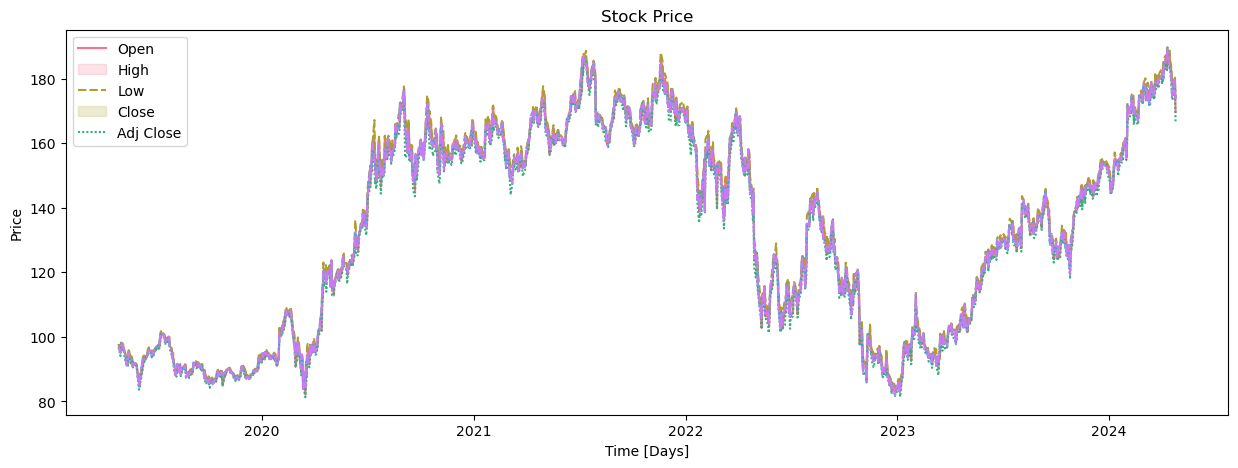

In [8]:
plt.figure(figsize=(15, 5))
palette = sns.color_palette("husl", 5)
sns.lineplot(data=dataset[['Open', 'High', 'Low', 'Close', 'Adj Close']],palette=palette) 
plt.title('Stock Price')
plt.xlabel('Time [Days]')
plt.ylabel('Price')
plt.legend(labels=['Open', 'High', 'Low', 'Close', 'Adj Close'], loc='best')
plt.show()

## Transform the data

We need to split our data into training and testing data. We will use only the *Close* column as that will be our target variable.

In [9]:
train_size = 0.8
split_index = int(train_size * len(dataset))

train_data = dataset['Close'][:split_index]
test_data = dataset['Close'][split_index:]

In [10]:
train_data[:5], 

(Date
 2019-04-29    96.921501
 2019-04-30    96.325996
 2019-05-01    95.575996
 2019-05-02    95.041000
 2019-05-03    98.123001
 Name: Close, dtype: float64,)

We will need to scale our data to work with smaller numbers.
> We are transforming and define the scaler on the train data

> And we only transform the data for the test

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data = scaler.transform(test_data.values.reshape(-1, 1))

In [12]:
train_data

array([[-1.03350536],
       [-1.05197204],
       [-1.07522965],
       ...,
       [-0.72221016],
       [-0.74546777],
       [-0.85834465]])

When working with time-series we need to work with sequences of data. So we defined a method that will create the sequences for us

In [13]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

We sets the number of time steps, meaning each sequence will contain a number of data points that matches the time steps.
> X_train, y_train = create_sequences(train_data, sequence_length): This creates sequences for the training data (X contains input sequences, and y contains corresponding labels).

We will do the same thing for the test data.

In [14]:
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


We can check how our data is looking after the sequencing

In [15]:
X_train[0], y_train[0]

(array([[-1.03350536],
        [-1.05197204],
        [-1.07522965],
        [-1.09181995],
        [-0.99624668],
        [-1.01471337],
        [-1.06053064],
        [-1.06553898],
        [-1.09329295],
        [-1.10862744]]),
 array([-1.21297648]))

In [16]:
X_train.shape, y_train.shape

((996, 10, 1), (996, 1))

In [17]:
X_test.shape, y_test.shape

((242, 10, 1), (242, 1))

## Create Model LSTM

We create a sequential model using an LSTM layer followed by 4 Dense output layers


In [18]:
model = Sequential([
    LSTM(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

We create a function to save the model when it reach the best performaces, based on the validation loss.

In [19]:
def create_checkpoint(model_path):
   model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
   return model_checkpoint
    

Define the optimizer and compile the model, then we train the model.

In [20]:
learning_rate = 0.001
# Compile the model
model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelLSTM.h5')])

Epoch 1/120
25/32 [======================>.......] - ETA: 0s - loss: 0.2755
Epoch 1: val_loss improved from inf to 0.02698, saving model to ModelLSTM.h5
32/32 [==============================] - 2s 21ms/step - loss: 0.2305 - val_loss: 0.0270
Epoch 2/120
25/32 [======================>.......] - ETA: 0s - loss: 0.0299
Epoch 2: val_loss did not improve from 0.02698
32/32 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.0297
Epoch 3/120
25/32 [======================>.......] - ETA: 0s - loss: 0.0257
Epoch 3: val_loss improved from 0.02698 to 0.01713, saving model to ModelLSTM.h5
32/32 [==============================] - 0s 7ms/step - loss: 0.0254 - val_loss: 0.0171
Epoch 4/120
30/32 [===========================>..] - ETA: 0s - loss: 0.0208
Epoch 4: val_loss improved from 0.01713 to 0.01310, saving model to ModelLSTM.h5
32/32 [==============================] - 0s 8ms/step - loss: 0.0208 - val_loss: 0.0131
Epoch 5/120
25/32 [======================>.......] - ETA: 0s 

We load the model with the best validation loss.

In [21]:
model = tf.keras.models.load_model('ModelLSTM.h5')

We evaluate the model.

In [22]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.008298051543533802
Test Loss: 0.006634097546339035


We are using the same scaler to transform our scaled predictions back to normal values (prices)

In [23]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
# Inverse transform the actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 2ms/step


We plot the prediction and the initial data

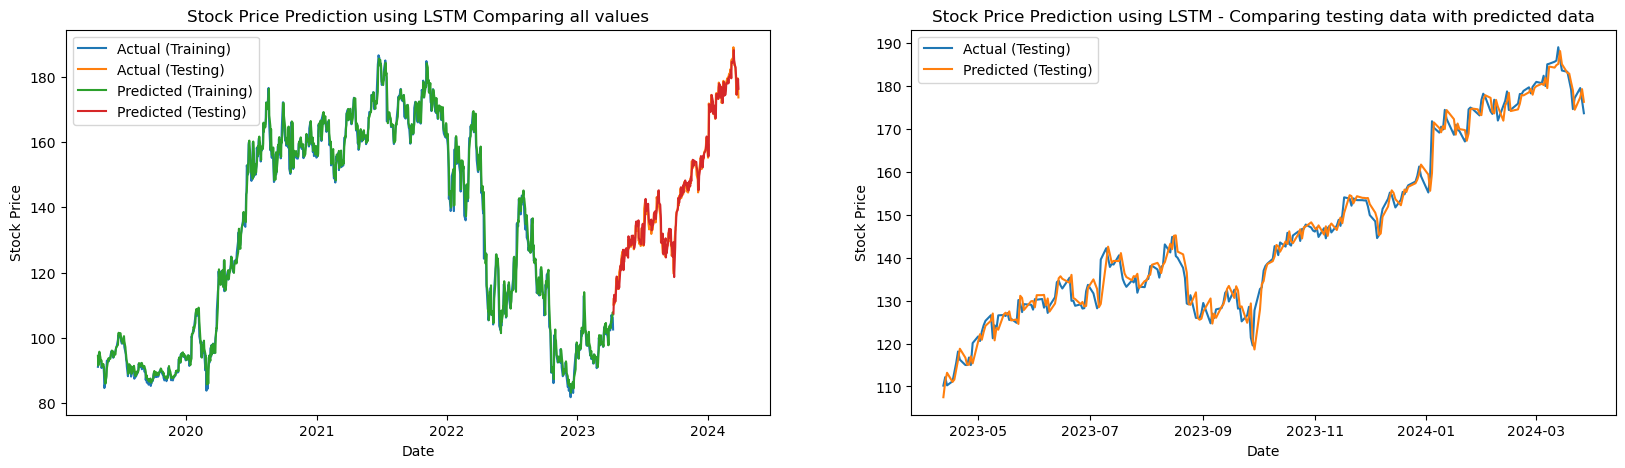

In [24]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[:len(train_predict)], train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(test_predict)], test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using LSTM Comparing all values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1,2,2)
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(test_predict)], test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using LSTM - Comparing testing data with predicted data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## GRU model

We will create a GRU model to see how it will perform

In [25]:
gru_model = Sequential([
    GRU(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

Define optimizer, compile and train the model

In [26]:
learning_rate = 0.001
# Compile the model
gru_model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

# Train the model
gru_model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelGRU.h5')])

Epoch 1/120
23/32 [====================>.........] - ETA: 0s - loss: 0.2077
Epoch 1: val_loss improved from inf to 0.02716, saving model to ModelGRU.h5
32/32 [==============================] - 2s 20ms/step - loss: 0.1598 - val_loss: 0.0272
Epoch 2/120
23/32 [====================>.........] - ETA: 0s - loss: 0.0192
Epoch 2: val_loss improved from 0.02716 to 0.01641, saving model to ModelGRU.h5
32/32 [==============================] - 0s 7ms/step - loss: 0.0172 - val_loss: 0.0164
Epoch 3/120
23/32 [====================>.........] - ETA: 0s - loss: 0.0133
Epoch 3: val_loss improved from 0.01641 to 0.01070, saving model to ModelGRU.h5
32/32 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0107
Epoch 4/120
23/32 [====================>.........] - ETA: 0s - loss: 0.0120
Epoch 4: val_loss improved from 0.01070 to 0.00823, saving model to ModelGRU.h5
32/32 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0082
Epoch 5/120
23/32 [============

We load the best GRU saved model.

In [27]:
gru_model = tf.keras.models.load_model('ModelGRU.h5')

Evaluate the model.

In [28]:
# Evaluate the model
train_loss = gru_model.evaluate(X_train, y_train, verbose=0)
test_loss = gru_model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.008444751612842083
Test Loss: 0.006634153425693512


We are using the same scaler to transform our scaled predictions back to normal values (prices)

In [29]:
# Predictions
gru_train_predict = gru_model.predict(X_train)
gru_test_predict = gru_model.predict(X_test)

# Inverse transform the predictions
gru_train_predict = scaler.inverse_transform(gru_train_predict)
gru_test_predict = scaler.inverse_transform(gru_test_predict)

# Inverse transform the actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 2ms/step


Plot the prediction and the initial data

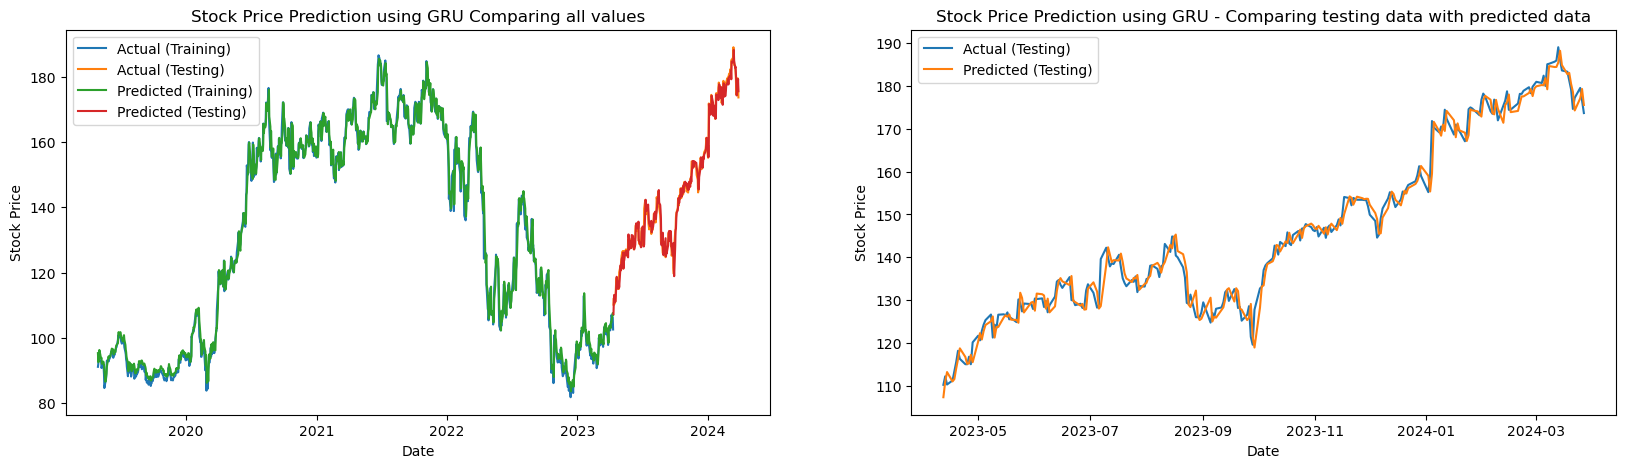

In [30]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[:len(gru_train_predict)], gru_train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(gru_test_predict)], gru_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using GRU Comparing all values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1,2,2)
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(gru_test_predict)], gru_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using GRU - Comparing testing data with predicted data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## RNN Simple model

Here we will try to use a SimpleRNN Model

In [31]:
rnn_model = Sequential([
    SimpleRNN(units=128, input_shape=(sequence_length, 1)),
    Dense(units=128, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

Define optimizers, compile and train the model.

In [32]:
learning_rate = 0.001
# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')

# Train the model
rnn_model.fit(X_train, y_train, epochs=120, batch_size=32 ,validation_data=(X_test, y_test), callbacks=[create_checkpoint('ModelSimpleRNN.h5')])

Epoch 1/120
24/32 [=====================>........] - ETA: 0s - loss: 0.1018 
Epoch 1: val_loss improved from inf to 0.01244, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 1s 12ms/step - loss: 0.0833 - val_loss: 0.0124
Epoch 2/120
23/32 [====================>.........] - ETA: 0s - loss: 0.0190
Epoch 2: val_loss improved from 0.01244 to 0.01076, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 0s 4ms/step - loss: 0.0181 - val_loss: 0.0108
Epoch 3/120
22/32 [===================>..........] - ETA: 0s - loss: 0.0144
Epoch 3: val_loss improved from 0.01076 to 0.01070, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.0107
Epoch 4/120
23/32 [====================>.........] - ETA: 0s - loss: 0.0141
Epoch 4: val_loss improved from 0.01070 to 0.00882, saving model to ModelSimpleRNN.h5
32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0088
Epoch 

Load the model.

In [33]:
rnn_model = tf.keras.models.load_model('ModelSimpleRNN.h5')

Evaluate the model.

In [34]:
# Evaluate the model
train_loss = rnn_model.evaluate(X_train, y_train, verbose=0)
test_loss = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

Training Loss: 0.008405772037804127
Test Loss: 0.006914655212312937


We are using the same scaler to transform our scaled predictions back to normal values (prices)

In [35]:
# Predictions
rnn_train_predict = rnn_model.predict(X_train)
rnn_test_predict = rnn_model.predict(X_test)

# Inverse transform the predictions
rnn_train_predict = scaler.inverse_transform(rnn_train_predict)
rnn_test_predict = scaler.inverse_transform(rnn_test_predict)

# Inverse transform the actual values
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 [==============================] - 0s 1ms/step


Plot the prediction and actual values.

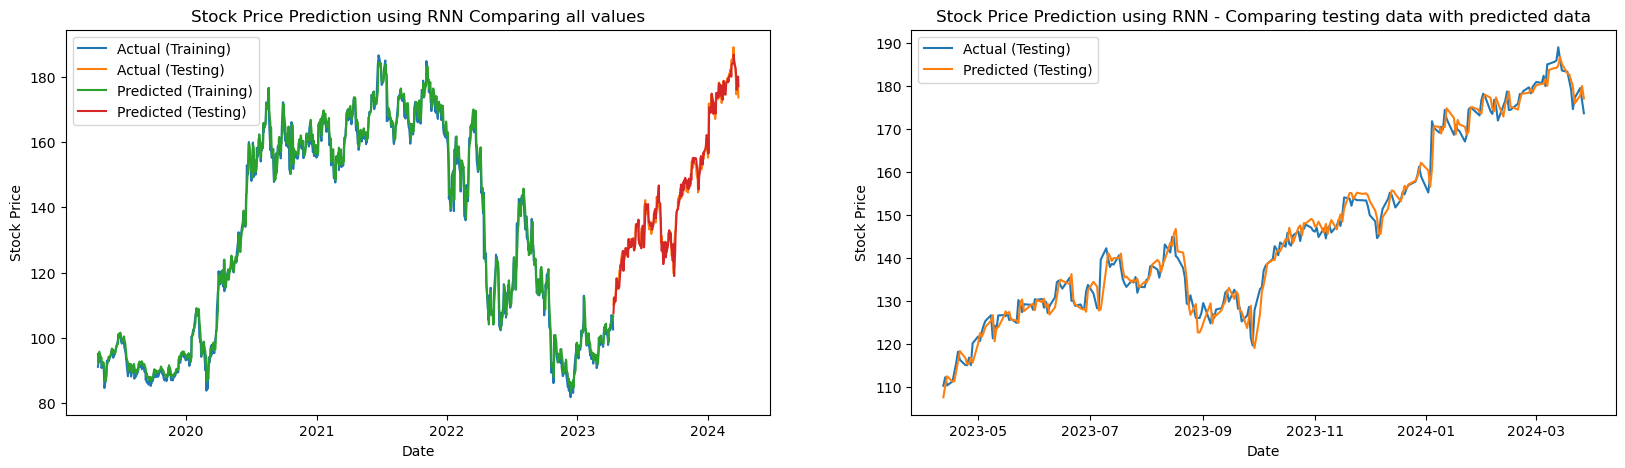

In [36]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.plot(dataset.index[:len(y_train_inv)], y_train_inv, label='Actual (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[:len(rnn_train_predict)], rnn_train_predict, label='Predicted (Training)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(rnn_test_predict)], rnn_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using RNN Comparing all values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

plt.subplot(1,2,2)
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(y_test_inv)], y_test_inv, label='Actual (Testing)')
plt.plot(dataset.index[len(y_train_inv):len(y_train_inv)+len(rnn_test_predict)], rnn_test_predict, label='Predicted (Testing)')
plt.title('Stock Price Prediction using RNN - Comparing testing data with predicted data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Model comparison

Let's compare all 3 models with actual price from today.

In [37]:
last_predicted_close_lstm = test_predict[-1][0]
last_predicted_close_gru = gru_test_predict[-1][0]
last_predicted_close_rnn = rnn_test_predict[-1][0]

print("Actual price: ", actual_close)
print("LSTM Prediction: ", last_predicted_close_lstm)
print("GRU Prediction: ", last_predicted_close_gru)
print("RNN Prediction: ", last_predicted_close_rnn)

Actual price:  179.6199951171875
LSTM Prediction:  176.32426
GRU Prediction:  175.55954
RNN Prediction:  177.10971


Than we can choose a model and we can predict the next days Close prices.

In [38]:

number_of_days=10
# To predict for the next days, you'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, sequence_length, 1)

# Generate predictions for the next days
predictions_next_days = []
for _ in range(number_of_days):
    next_day_prediction = model.predict(last_sequence, verbose=0)
    predictions_next_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction[0, 0]  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_days = scaler.inverse_transform(np.array(predictions_next_days).reshape(-1, 1))

# Print the predictions for the next days
print(f"Predictions for the next {number_of_days} days:")
for i, prediction in enumerate(predictions_next_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

Predictions for the next 10 days:
Day 1: Predicted Price = 176.3242645263672
Day 2: Predicted Price = 176.2813720703125
Day 3: Predicted Price = 176.21788024902344
Day 4: Predicted Price = 176.1446075439453
Day 5: Predicted Price = 176.06539916992188
Day 6: Predicted Price = 175.98471069335938
Day 7: Predicted Price = 175.90562438964844
Day 8: Predicted Price = 175.83010864257812
Day 9: Predicted Price = 175.75848388671875
Day 10: Predicted Price = 175.6903533935547
